In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

 99% 2.03G/2.04G [00:14<00:00, 60.0MB/s]
100% 2.04G/2.04G [00:14<00:00, 150MB/s] 


In [3]:
!unzip plantvillage-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

# Foliar Disease Classification via pretrained CNNs (Self Defined CNN) in Various Crop Leaves (Plant Village Dataset)

# Introduction

In this notebook we try understand the workings of a CNN model by building one. The model will be trained on the Plant Village Dataset for identifying plant pathologies and categorizing in 38 classes. The focus is to explore building a self defined CNN to test on the dataset.

The dataset utilized in this experiment comprises more than 50,000+ RGB images.

The following sections in the notebook will provide the necessary insights to arrive at the conclusion:

1. **Exploratory data analysis:**<br/>
The distribution of records per label, dataset size, and structure.
2. **Data preprocessing:**<br/>
Upsampling, data augmentation, and the train-test split procedure.
Parallel image processing methods for computational efficiency optimization.
3. **Model architectures:**<br/>
Self Defined simple CNN architecture like the VGGNet.
4. **Model results:**<br/>
An overview of each model's runtime, training and testing accuracy scores.
Suggestions for potential improvements to enhance the models' performance in plant pathology detection.

# Libraries and Raw Data

## Libraries

In [4]:
# import system libs
import os
import time

# EDA and Data Handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

## Building the sets

The dataset is not divided into train and test sets. Also, the dataset contains colour (RGB), grayscale and segmented images. Since our interest is dealing in colour images, we divide the samples from it into train and val folders in 80:20 fashion

In [5]:
import shutil
import random

# Directory containing your data organized by classes
data_dir = 'plantvillage dataset/color'

# Directory where you want to store the separated training and validation data
train_dir = 'train'
val_dir = 'val'

# Create train and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Fraction of data to use for validation
validation_split = 0.2

# Loop through each class directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # Create class directories in train and validation directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Get list of image filenames in class directory
        images = os.listdir(class_dir)

        # Shuffle the images
        random.shuffle(images)

        # Calculate number of images for validation
        num_val_images = int(len(images) * validation_split)

        # Move images to validation directory
        for img in images[:num_val_images]:
            src = os.path.join(class_dir, img)
            dst = os.path.join(val_dir, class_name, img)
            shutil.copy(src, dst)

        # Move remaining images to training directory
        for img in images[num_val_images:]:
            src = os.path.join(class_dir, img)
            dst = os.path.join(train_dir, class_name, img)
            shutil.copy(src, dst)

print("Data separated into train and validation sets.")

Data separated into train and validation sets.


## Raw Data (Data Loading), Data Augmentation and Data Preprocessing

In [6]:
BATCH_SIZE = 32
NUM_CLASSES = 38
NUM_EPOCHS = 5
IMAGE_SIZE = 256

## Dataset Pipeline

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    vertical_flip=True,
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest',  # Strategy for filling in newly created pixels
)

# Use flow_from_directory to load images and apply transformations
train_generator = train_datagen.flow_from_directory(
    'train',  # Path to the directory with training data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # All images will be resized to 150x150
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For multi-class classification
)

class_names = train_generator.class_indices.keys()

Found 43456 images belonging to 38 classes.


In [8]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    'val',  # Path to the directory with training data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # All images will be resized to 150x150
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # For multi-class classification
)

Found 10849 images belonging to 38 classes.


# Exploratory data analysis

## Images

In [ ]:
def plot_images(images_arr, labels):
    fig, axes = plt.subplots(4, 5, figsize=(16, 9))  # 4 rows, 5 columns
    axes = axes.flatten()
    for img, ax, lbl in zip(images_arr, axes, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(lbl)
    plt.tight_layout()
    plt.show()

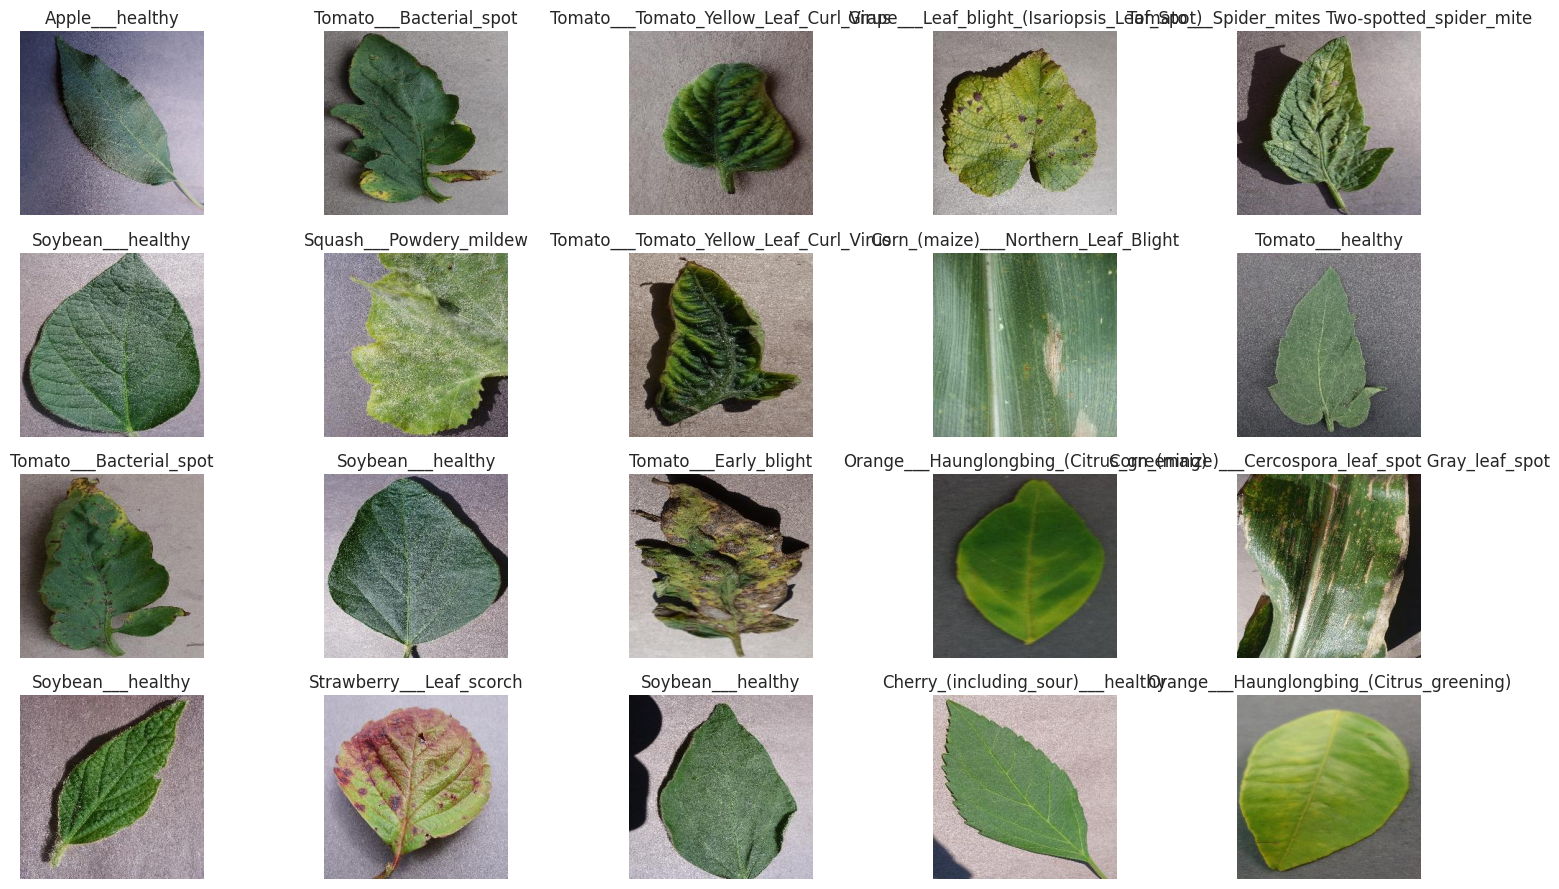

In [ ]:
# Get a batch of images and labels
sample_images, sample_labels = next(val_generator)

# Convert one-hot encoded labels to actual class names
sample_labels = np.argmax(sample_labels, axis=1)
sample_labels = [list(class_names)[label] for label in sample_labels]

# Plot the images
plot_images(sample_images[:20], sample_labels[:20])

## Checking Class Distribution (records/label)

The bargraph below shows uneven distribution of records in labels (class imbalance). To fix this we will increase the number of samples in smaller classes to match with the larger ones. But since the dataset is too large, and the experiment's aim is to build a self-desined CNN, we would be avoiding it dur to time and resource constraints.

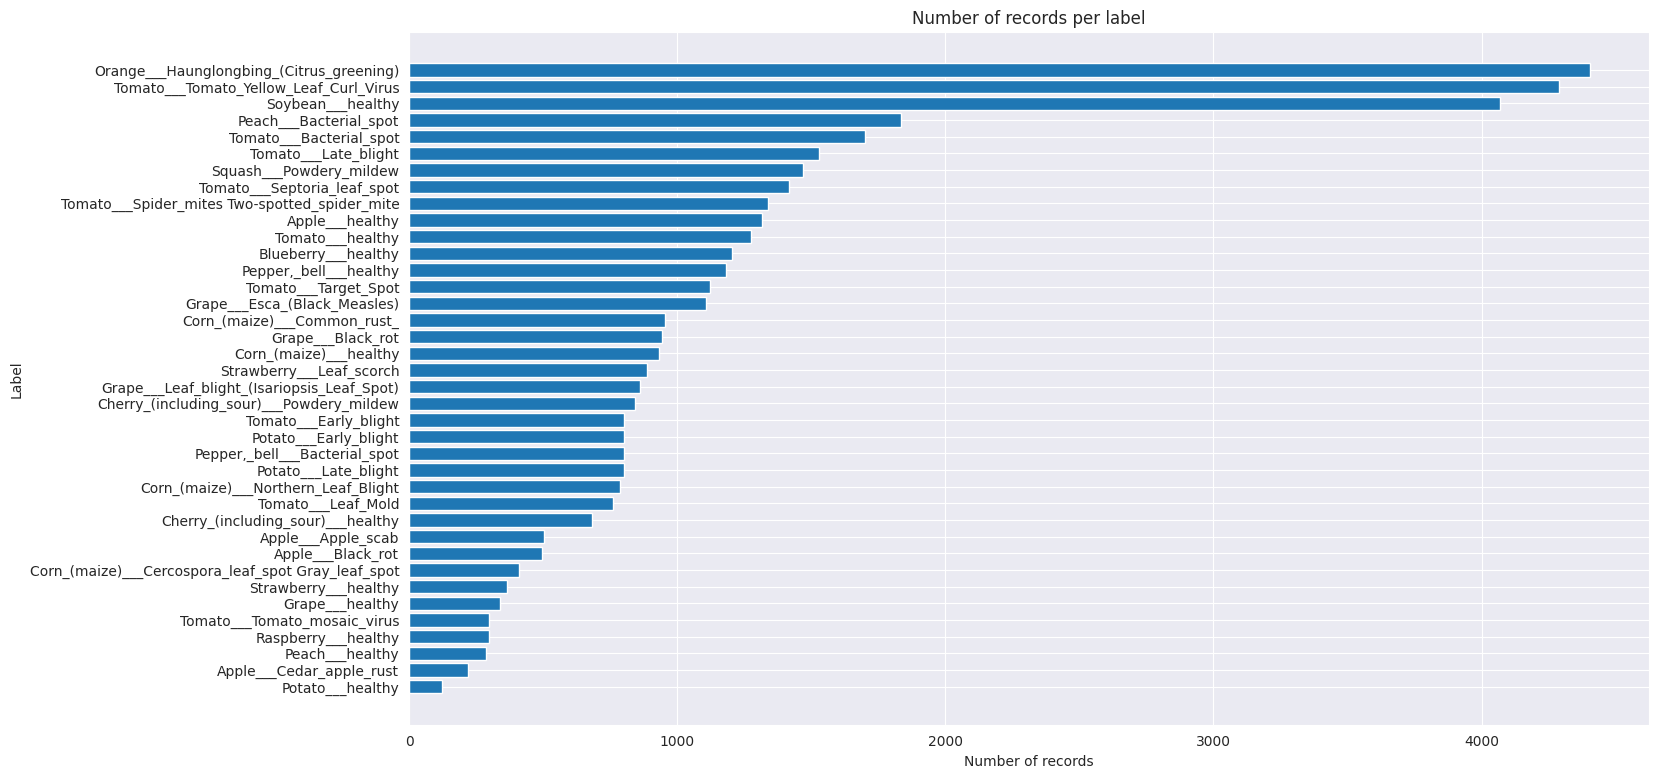

In [ ]:
class_counts = dict(zip(class_names, np.zeros(len(class_names))))

for _ in range(len(train_generator)):
    images, labels = next(train_generator)
    labels = np.argmax(labels, axis=1)  # Convert one-hot to indices
    for label in labels:
        class_counts[list(class_names)[label]] += 1

sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1]))

# Plot the horizontal bar plot
plt.figure(figsize=(16, 9))
plt.barh(list(sorted_class_counts.keys()), list(sorted_class_counts.values()))
plt.xlabel('Number of records')
plt.ylabel('Label')
plt.title('Number of records per label')
plt.show()

# Model Architectures

This architecture follows a typical pattern for convolutional neural networks (CNNs) commonly used in image classification tasks. It begins with a series of convolutional layers followed by max-pooling layers, which together help extract and capture relevant features from the input images. The initial convolutional layers with increasing filter sizes (32, 64, and 128) allow the model to learn increasingly complex patterns and representations. Subsequent max-pooling layers reduce the spatial dimensions of the feature maps, aiding in reducing computational complexity and extracting dominant features. The final layers consist of fully connected (dense) layers, which further process the extracted features before producing the final classification output through a softmax activation function. The inclusion of dropout regularization before the output layer helps prevent overfitting by randomly dropping a fraction of the neuron units during training.

In [9]:
def get_model():
    """
    Return compiled model.

    Args:
        func: function to get model architecture
    Returns:
        compiled_model: compiled tensorflow model
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

    return model

# Model results

In [10]:
def plot_model_scores(scores, losses, model_name):
    """
    Plot train and test accuracy scores and losses of a model by epoch
    """
    train_scores, test_scores = scores
    train_loss, test_loss = losses
    epochs = range(1, len(train_scores) + 1)

    # Plot accuracy scores
    plt.figure(figsize=(16, 9))
    plt.plot(epochs, train_scores, label='Train score', color='b')
    plt.plot(epochs, test_scores, label='Test score', color='g')
    plt.title('Train and test accuracy scores of {}'.format(model_name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot losses
    plt.figure(figsize=(16, 9))
    plt.plot(epochs, train_loss, label='Train loss', color='r')
    plt.plot(epochs, test_loss, label='Test loss', color='y')
    plt.title('Train and test losses of {}'.format(model_name))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_classification_report(model, val_generator):
    """
    Print classification report for the model on the validation set.

    Args:
        model: trained model
        val_generator: validation data generator
    """
    predictions = model.predict(val_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)

def get_model_results(model_name, train_generator, val_generator):
    """
    Return tuple of runtime, train and test scores, training and validation loss.
    Compile, fit and save model along the way.

    Args:
        model_name: Name of the model
        model: fitted model
        train_generator: training data generator
        val_generator: validation data generator
    Returns:
        (runtime, (train_scores, val_scores), (train_loss, val_loss) )
    """
    model = get_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=val_generator, callbacks=[early_stopping])

    model.save('{}'.format(model_name))
    model.save('{}.keras'.format(model_name))
    model.save('{}.h5'.format(model_name))
    # model.save('{}.keras'.format(model_name))

    # Extract training and validation scores
    train_scores = history.history['categorical_accuracy']
    val_scores = history.history['val_categorical_accuracy']

    # Extract training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Generate classification report
    # print("Classification Report:")
    # print_classification_report(model, val_generator)

    # Clear session to release memory
    tf.keras.backend.clear_session()

    return (train_scores, val_scores), (train_loss, val_loss)

# Model Performance

The self-defined CNN architecture demonstrates notable performance improvements over the course of training, as evidenced by the increasing categorical accuracy and decreasing loss values across epochs.

In the initial epoch, the model achieved a moderate categorical accuracy of approximately 26.82% on the training data and 47.99% on the validation data, indicating room for improvement. However, as training progresses, the model's accuracy steadily increases, reaching 61.31% on the training data and a promising 73.16% on the validation data by the fifth epoch.

The decreasing loss values also suggest that the model is effectively learning and minimizing prediction errors as training progresses. This improvement in performance indicates that the model's architecture is capable of capturing relevant patterns and features from the input data, leading to more accurate predictions.

In [11]:
scores, losses = get_model_results('self-created', train_generator, val_generator)

Epoch 1/5
1358/1358 [==============================] - 800s 582ms/step - loss: 2.7313 - categorical_accuracy: 0.2682 - val_loss: 1.8746 - val_categorical_accuracy: 0.4799
Epoch 2/5
1358/1358 [==============================] - 765s 563ms/step - loss: 2.0879 - categorical_accuracy: 0.4065 - val_loss: 1.8435 - val_categorical_accuracy: 0.4754
Epoch 3/5
1358/1358 [==============================] - 765s 563ms/step - loss: 1.6983 - categorical_accuracy: 0.5003 - val_loss: 1.1007 - val_categorical_accuracy: 0.6626
Epoch 4/5
1358/1358 [==============================] - 772s 569ms/step - loss: 1.4141 - categorical_accuracy: 0.5714 - val_loss: 1.0032 - val_categorical_accuracy: 0.7043
Epoch 5/5
1358/1358 [==============================] - 764s 563ms/step - loss: 1.2725 - categorical_accuracy: 0.6131 - val_loss: 0.8581 - val_categorical_accuracy: 0.7316


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


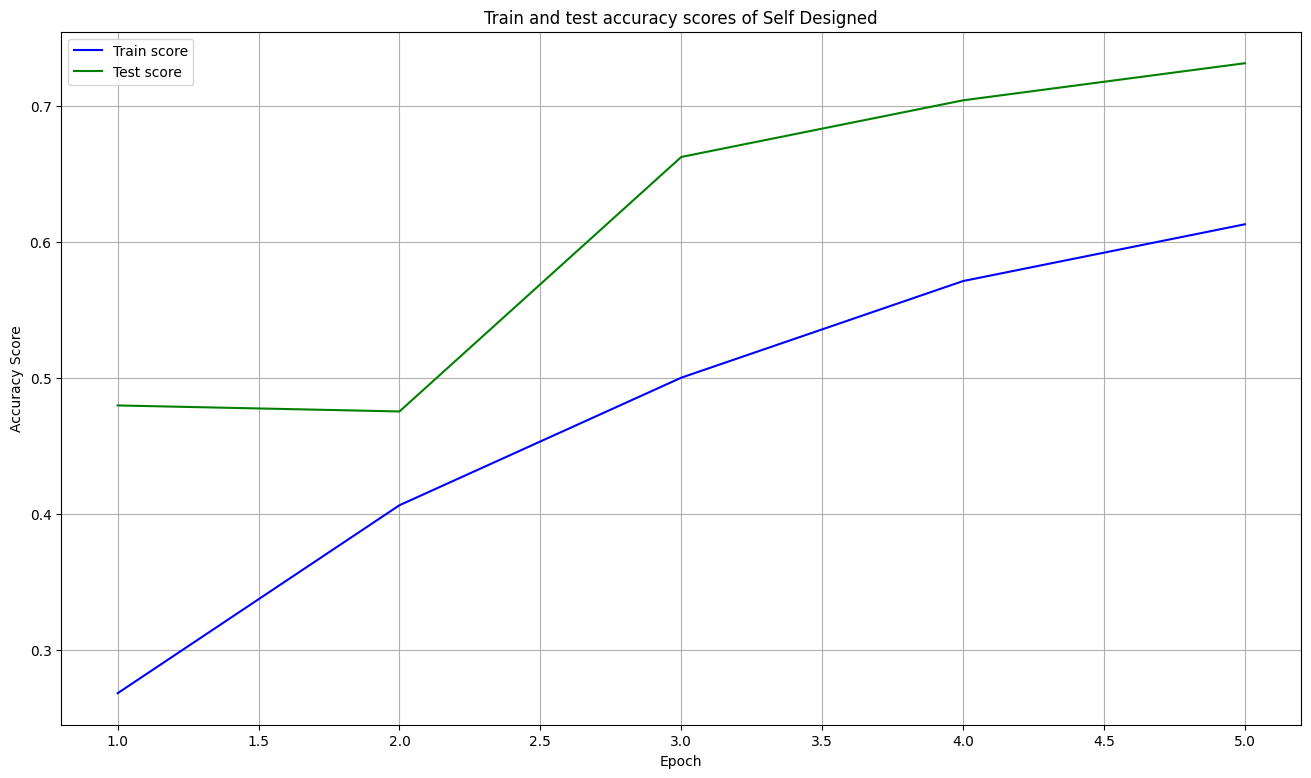

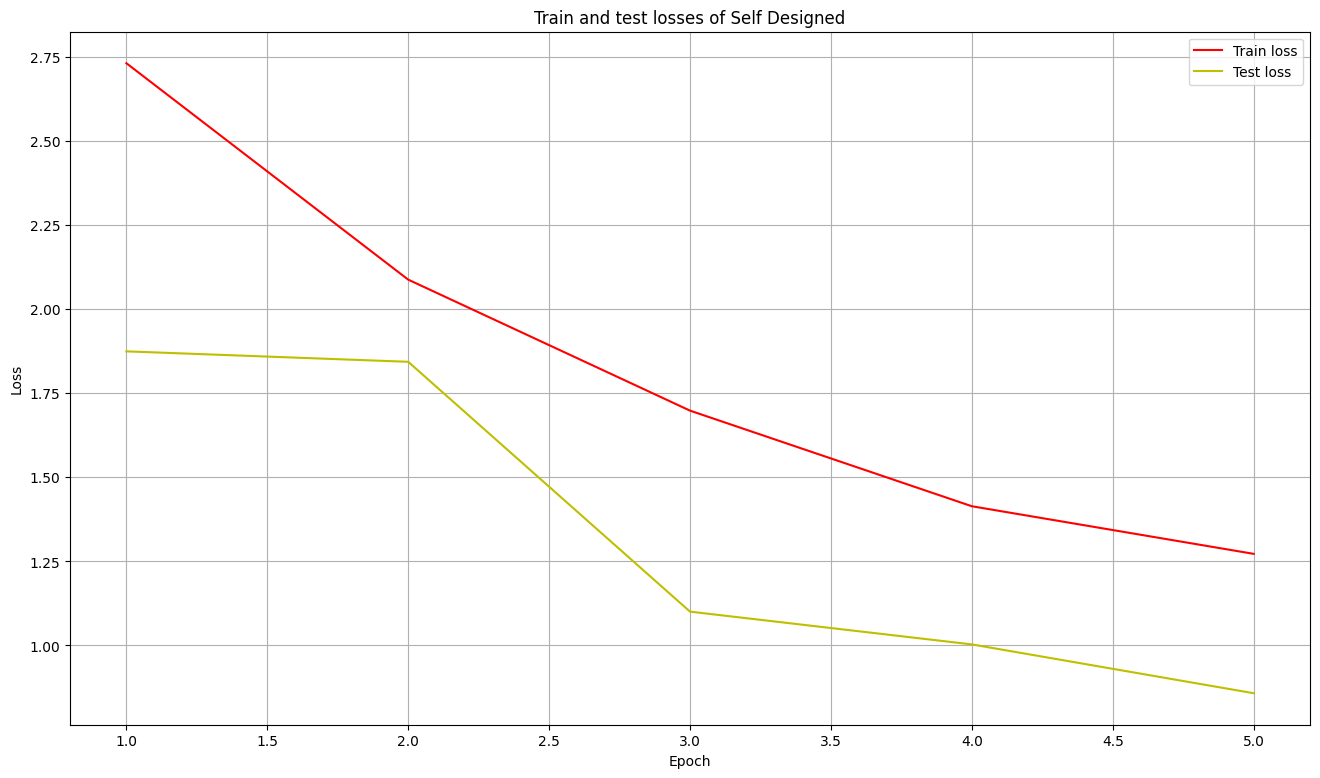

In [12]:
plot_model_scores(scores, losses, 'Self Designed')

In [ ]:
!zip -r /content/self-created.zip /content/self-created/

from google.colab import files
files.download("/content/self-created.zip")

In [ ]:
!zip -r /content/h5_self-created.zip /content/self-created.h5

from google.colab import files
files.download("/content/h5_self-created.zip")

In [ ]:
!zip -r /content/keras_self-created.zip /content/self-created.keras

from google.colab import files
files.download("/content/keras_self-created.zip")

# Metrics and Conclusion

The self-designed CNN, in the Plant Village dataset, although gaining good accuracy in the first 5 epochs seems to have failed on precision, recall and f1 scores. The humungous amount of data, which is also imbalanced, has created these results. It is only by training the model for longer, and the model being deeper, will help in rectifying this issue. 

In [18]:
from tensorflow.keras.models import load_model
model = load_model('self-created.h5')
print_classification_report(model, val_generator)

340/340 [==============================] - 21s 62ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.08      0.02      0.03       126
                                 Apple___Black_rot       0.01      0.01      0.01       124
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.04      0.03      0.04       329
                               Blueberry___healthy       0.02      0.02      0.02       300
          Cherry_(including_sour)___Powdery_mildew       0.01      0.00      0.01       210
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       102
                       Corn_(maize)___Common_rust_       0.05      0.05      0.05       238
               Corn_(m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
def display_images_with_predictions_from_generator(model, generator, num_images=9):
    class_labels = list(generator.class_indices.keys())  # Get class labels from the generator
    plt.figure(figsize=(15, 15))

    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    predictions = model.predict(images)
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)

        # Denormalize the image (assuming normalization to 0-1 range)
        img = (images[i] * 255).astype('uint8')

        plt.imshow(img)

        predicted_class_idx = np.argmax(predictions[i])
        predicted_class = class_labels[predicted_class_idx]
        confidence = predictions[i][predicted_class_idx] * 100

        actual_class_idx = np.argmax(labels[i])
        actual_class = class_labels[actual_class_idx]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}%")
        plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 208ms/step


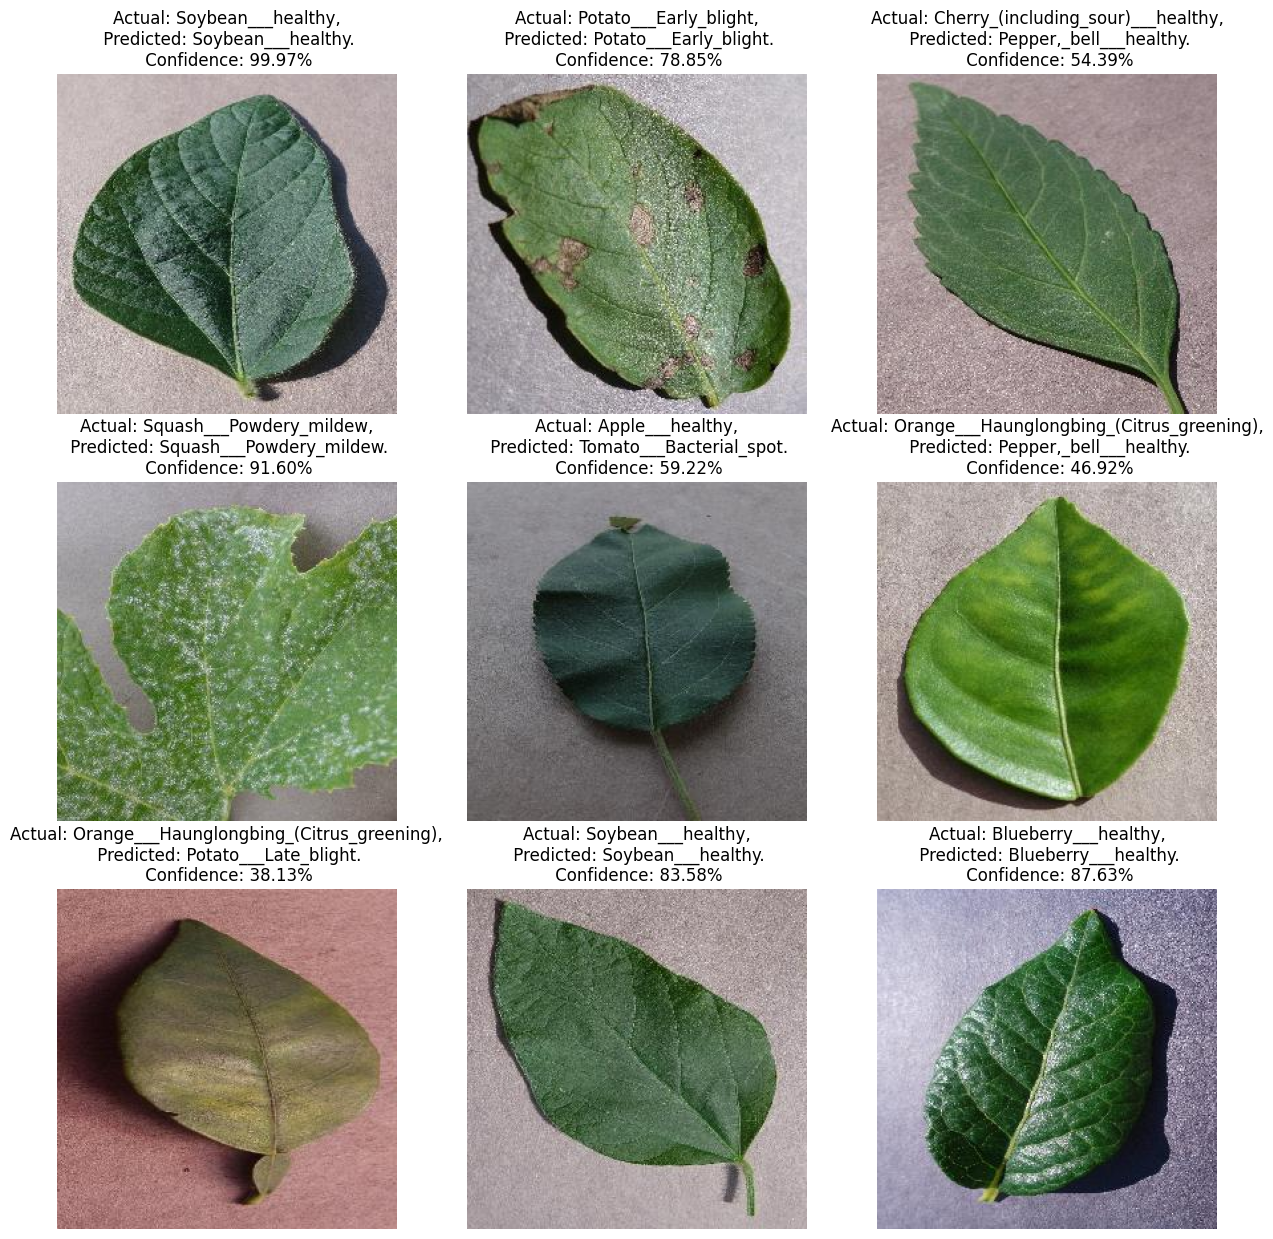

In [20]:
display_images_with_predictions_from_generator(model, val_generator)